# Part a
This notebook contains a step-by-step walkthrough of task a) using both code and text.

In [13]:
%load_ext autoreload
%autoreload 2
#Add own modules to path
import sys
sys.path.append('../..')
sys.path.append('../../src/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the data and constructing the design matrix
In this part the terrain data used in previous project will be used again. 100x100 data points is extracted from the data and will be the default amount of data points.

For simplicity one function has been created and is used to load the data and create the design matrix. Degree 4 is choosen for the polynomial design matrix and will be used in further analyses.

In [14]:
from src.data.create_dataset import create_dataset
X, z = create_dataset('../../data/raw/SRTM_data_Norway_1.tif',degree=8) 

### Splitting and plotting the data

/home/oliverif/courses/AppliedDataAnalysis/projects/FYS-STK4155-project2/notebooks/Reports/../../src/visualization/visualize.py:45: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Test data'}, xlabel='X', ylabel='Y'>

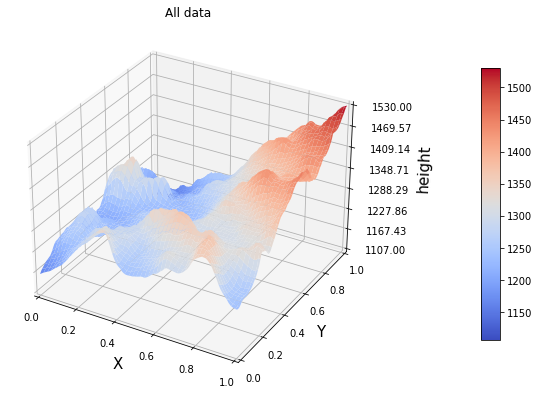

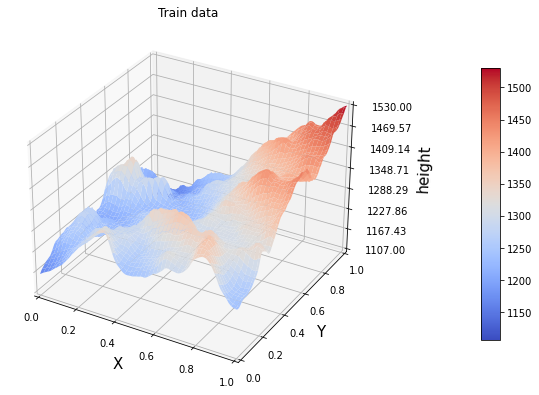

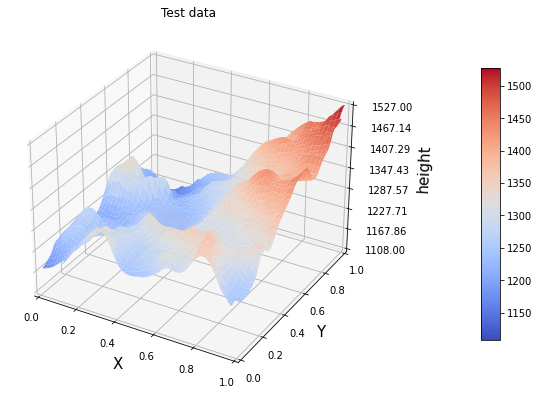

In [15]:
from src.visualization.visualize import plot_surf_from_X
from sklearn.model_selection import  train_test_split

X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)

plot_surf_from_X(X,z,'All data')
plot_surf_from_X(X_train,z_train,'Train data')
plot_surf_from_X(X_test,z_test,'Test data')

Above plots shows z, z_train and z_test plotted on a 2 by 2 grid spanning 0 to 1. Cubic interpolation is used to fill in the blanks, but some are not possible to interpolate to because they lie outside the convex hull of the data, meaning there's no data point on the other side to use in interpolation.

As can be seen, they're not very easy to distinguish to the naked eye, but it is at least clear from the test data that some details are missing given it's smooth curves.

Anyhow, interpolation enables us to plot a smooth surface containing the predicted values of our future model.

### Scaling the data
The data is scaled using SKlearn's StandardScaler. Here standardization is used by subtracting the mean and dividing by std. The reason is that it helps the stochastic gradient descent algorithm converge faster, as it reduces the amount of steps needed to reach a good or optimal solution. This is because when standardizing there are less ravines(i.e mixture of steep and flat directions), which an sgd algorithm doesn't tend to handle very well. A steep hill will cause a big gradient that may in turn cause the sgd to overshoot at the next step. Standardizing ensures the parameter space is homogenous(i.e error ellipsis shown in image is more circular).

![standardization](../../figures/standardization_sgd.PNG)

(source: <i>Python Machine Learning - Second Edition</i>, by Sebastian Raschka & Vahid Mirjalili)

This is an argument for scaling the features, X and not the target data, z. However, as we will see later when fitting neural networks, high values of z can lead to initial errors being large which again may cause exploding gradients.
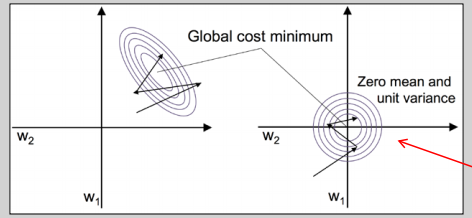

/home/oliverif/courses/AppliedDataAnalysis/projects/FYS-STK4155-project2/notebooks/Reports/../../src/visualization/visualize.py:45: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Scaled test data'}, xlabel='X', ylabel='Y'>

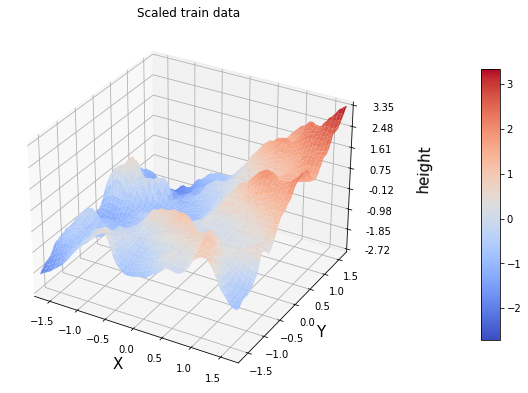

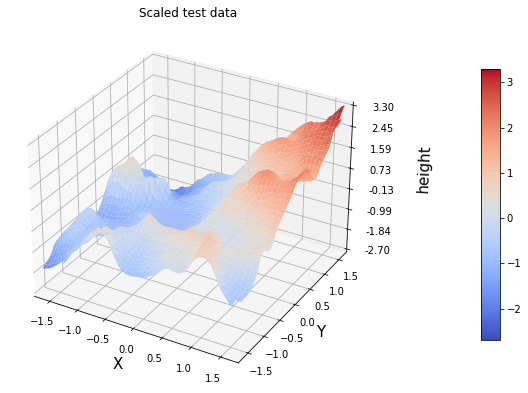

In [16]:
from sklearn.preprocessing import StandardScaler
X_scl = StandardScaler().fit(X_train)
z_scl = StandardScaler().fit(z_train)

X_train = X_scl.transform(X_train)
X_test = X_scl.transform(X_test)
z_train = z_scl.transform(z_train)
z_test = z_scl.transform(z_test)
plot_surf_from_X(X_train,z_train,'Scaled train data')
plot_surf_from_X(X_test,z_test,'Scaled test data')

### Revisiting regular OLS and Ridge
OLS and Ridge using matrix inversion was studied in former project, but will be presented here to provide basis for comparison. As the squared erro cost function is convex, any local minima is the a global minima. As such, a solution using sgd will converge towards the analytical solution(i.e the optimal solution) with enough iterations and low enough learning rate.

In [17]:
from src.modelling.linreg import LinReg
import numpy as np
lmb = 0.1
ols =LinReg(regularization = None).fit(X_train,z_train)
ridge = LinReg(regularization = 'l2', lmb = lmb).fit(X_train,z_train)

print('OLS\t','\tRidge')
print(np.column_stack((ols.beta,ridge.beta)))

OLS	 	Ridge
[[    0.             0.        ]
 [    5.04961783     2.6770965 ]
 [    3.1234112      1.58284097]
 [  -12.61770063    -5.67534244]
 [  -75.37651898    -2.05201208]
 [   49.23467878    -5.14847345]
 [  142.03802475     2.91548227]
 [   82.28923588     3.17777999]
 [  423.04389261    -6.52970717]
 [ -463.76722455     7.24174327]
 [ -837.39114415     3.25902019]
 [  464.6683219      1.59389816]
 [-1112.30273697     3.7149008 ]
 [ -753.00986534     1.78092352]
 [ 1379.0101154      1.78564167]
 [ 2012.13271376    -0.04473107]
 [-1064.1649761     -2.92752999]
 [  578.77711013     5.47574038]
 [ 2228.6416953     -0.38451458]
 [  351.9663875      3.36248666]
 [-1811.59399372    -4.53471387]
 [-2318.10011752    -2.53569787]
 [  619.5548408     -3.99022338]
 [  807.63215289     3.49673133]
 [-1858.65025218    -3.84262718]
 [-1791.5659559     -3.59995942]
 [  396.25900941     3.38060853]
 [  971.72486569    -4.2726307 ]
 [ 1286.05614804    -2.07294965]
 [   85.92867598    -1.14083005

The columns above show beta values for ols and ridge respectively. As can be seen, some of the higher parameters have been dampened with Ridge

OLS train[MSE,R2]: (0.04718248144957368, 0.9528175185504263) 
OLS test[MSE,R2]: (0.04959403836054341, 0.9506093803978954)
Ridge train[MSE,R2]: (0.04718248144957368, 0.9528175185504263) 
Ridge test[MSE,R2]: (0.04959403836054341, 0.9506093803978954)


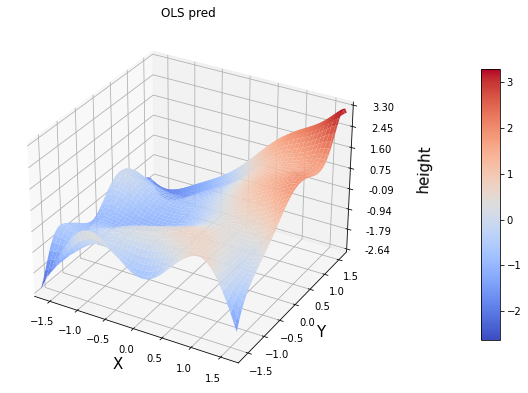

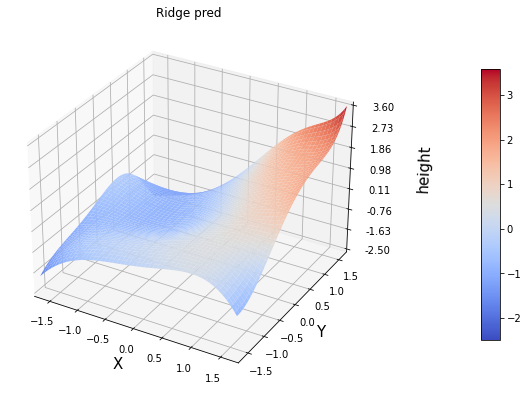

In [18]:
from src.model_evaluation.metrics import MSE_R2
#Predict test and train
z_tilde_ols = ols.predict(X_train)
z_pred_ols = ols.predict(X_test)
z_tilde_ridge = ridge.predict(X_train)
z_pred_ridge = ridge.predict(X_test)

#Score the models
train_mse_ols, train_r2_ols = MSE_R2(z_train,z_tilde_ols)
test_mse_ols, test_r2_ols = MSE_R2(z_test ,z_pred_ols)
train_mse_ridge, train_r2_ridge = MSE_R2(z_train,z_tilde_ols)
test_mse_ridge, test_r2_ridge = MSE_R2(z_test ,z_pred_ols)

#Concatenating X_train and X_test so that we 
#can plot the whole predicted surface
X_ = np.concatenate((X_train,X_test))

plot_surf_from_X(X_,np.concatenate((z_tilde_ols,z_pred_ols)),'OLS pred')
plot_surf_from_X(X_,np.concatenate((z_tilde_ridge,z_pred_ridge)),'Ridge pred')

#Printing the scores
print('OLS train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS test[MSE,R2]:',(test_mse_ols, test_r2_ols))
print('Ridge train[MSE,R2]:',(train_mse_ridge, train_r2_ridge), '\nRidge test[MSE,R2]:',(test_mse_ridge, test_r2_ridge))

The scores indicate a relatively good fit. The MSE is low in both cases, the scale is also quite low, however we also see that the R2 score is quite close to 1, indicating a good fit. From the looks of it, the surfaces doesn't look very much like the original, but a lot smoother. If the goal is to recreate terrain for visual purposes we might require an even better score and a higher complexity model.

### Regression using stochastic gradient descent
In place of matrix inversion when fitting parameters, we will in this case use sgd optimization.
To begin with, some parameters are set rather arbitrarily. Batch_size is 64 as a multiplum of 2 often enables more efficient vectorized calculations. The number of epochs are set to 100, which is low but demonstrates how sgd needs certain amounts of epochs to converge. Learning rate is set to 0.01, and when using regularization, lmb is set to 0.1. For demonstration purposes, the polynomial degree of the design matrix is tuned back to 4 as it results in fewer beta values to print out. Note that for robust benchmarking of models cross validation should be used, however, the initial objective here is to study the effects of the different parameters and techniques surrounding sgd.

OLS train[MSE,R2]: (0.1111957834838689, 0.8888042165161311) 
OLS test[MSE,R2]: (0.11327036426432628, 0.8868397525051505)
Ridge train[MSE,R2]: (0.1111957834838689, 0.8888042165161311) 
Ridge test[MSE,R2]: (0.11327036426432628, 0.8868397525051505)


,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,2.964406,0.200224,2.405939,0.191243
2,1.724189,0.078314,1.351290,0.078089
3,-6.191043,0.789532,-4.449319,0.793274
4,-7.089293,-0.764563,-6.263113,-0.768638
5,-3.389769,0.029245,-2.347487,0.045174
6,6.790784,0.157264,4.815371,0.159528
7,9.220758,0.679214,8.214406,0.679108
8,2.552918,-0.219275,1.933867,-0.216521


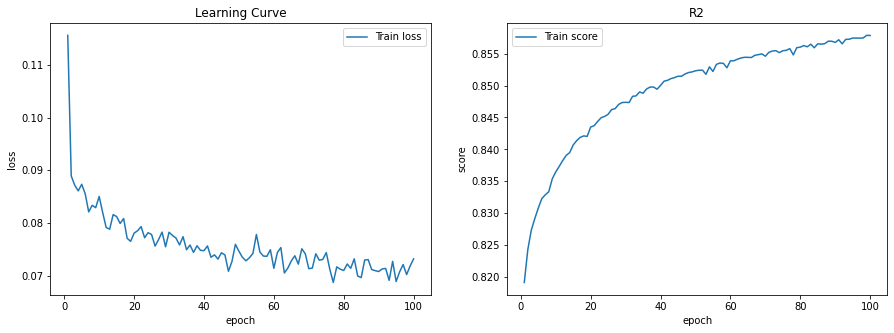

In [19]:
from src.modelling.linreg import SGD_linreg
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

X, z = create_dataset('../../data/raw/SRTM_data_Norway_1.tif',degree=4)
X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2) 
X_scl = StandardScaler().fit(X_train)
z_scl = StandardScaler().fit(z_train)
X_train = X_scl.transform(X_train)
X_test = X_scl.transform(X_test)
z_train = z_scl.transform(z_train)
z_test = z_scl.transform(z_test)

#OLS
ols =LinReg(regularization = None).fit(X_train,z_train)
ridge = LinReg(regularization = 'l2', lmb = lmb).fit(X_train,z_train)
#Predict test and train
z_tilde_ols = ols.predict(X_train)
z_pred_ols = ols.predict(X_test)
z_tilde_ridge = ridge.predict(X_train)
z_pred_ridge = ridge.predict(X_test)
#Score the models
train_mse_ols, train_r2_ols = MSE_R2(z_train,z_tilde_ols)
test_mse_ols, test_r2_ols = MSE_R2(z_test ,z_pred_ols)
train_mse_ridge, train_r2_ridge = MSE_R2(z_train,z_tilde_ols)
test_mse_ridge, test_r2_ridge = MSE_R2(z_test ,z_pred_ols)
#Printing the scores
print('OLS train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS test[MSE,R2]:',(test_mse_ols, test_r2_ols))
print('Ridge train[MSE,R2]:',(train_mse_ridge, train_r2_ridge), '\nRidge test[MSE,R2]:',(test_mse_ridge, test_r2_ridge))

#SGD OLS
lmb = 0.1
batch_size = 64
n_epochs = 100
lr0 = 0.01
val_fraction = 0
#initialize SGD linreg
sgd_ols = SGD_linreg(regularization = None, 
                     momentum= 0,
                     lr0=lr0,
                     batch_size = batch_size, 
                     n_epochs = n_epochs,
                     val_fraction = val_fraction
                     )
sgd_ridge = SGD_linreg(regularization = 'l2',lmb=0.001,
                       momentum= 0,
                       lr0=lr0,
                       batch_size = batch_size, 
                       n_epochs = n_epochs,
                       val_fraction=val_fraction
                       )

#Fit sgd optimizer
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'

fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

It can be seen that the parameters resulting from the SGDs does have a way to go to reach the analytical solutions. Note that since the cost functions(both with and without regularization) are convex, the sgd should converge to the analytical solution with enough epochs and low enough learning rate. It is clear that loss and score imporves with increase epochs. From the learning curve of OLS it can be observed that the curve is still decreasing at 100 epochs which may indicate that the optimizer have not yet converged fully. Similarily, from the score plot it can be seen the score is still increasing when the training finished. The batch size will then determine the amount of batches to use, thereby the amount of updates on each epoch. n_batches = n_samples/batch_size.

#### Epochs
Number of epochs are number of times the optimizer iterates over it's batches. Increasing this would give the optimizer more 'time' to converge. Now increasing number of epochs to 10 000.

,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,2.964406,2.200365,2.405939,1.932985
2,1.724189,1.195496,1.351290,1.020707
3,-6.191043,-3.543163,-4.449319,-2.866413
4,-7.089293,-6.225201,-6.263113,-5.660297
5,-3.389769,-1.728397,-2.347487,-1.368118
6,6.790784,3.497411,4.815371,2.911149
7,9.220758,8.254164,8.214406,7.515693
8,2.552918,1.777537,1.933867,1.417124


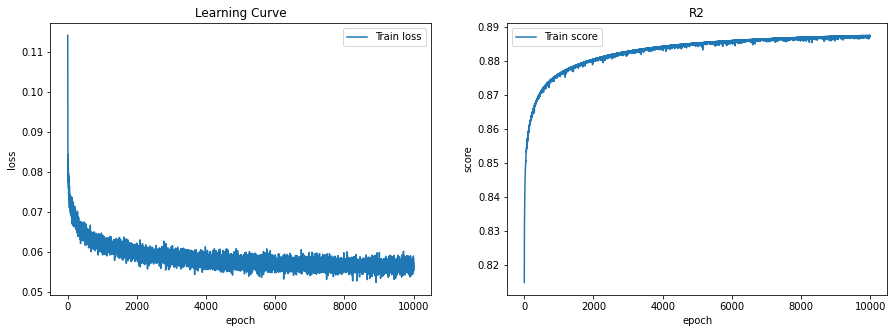

In [20]:
n_epochs = 10000

sgd_ols.set_params(n_epochs=n_epochs)
sgd_ridge.set_params(n_epochs=n_epochs)

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'

fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

Loss and score are still somewhat improving upon termination, however much less. The parameters are still relatively different from the analytical ones. This may indicate that it doesn't take much to achieve score above 86%, but substantially harder to improve the latter 14%. Increasing the number of epochs may improve the results. Though, running this took about 4,5 minutes which doesn't exactly allow for quick prototyping. As a more complex design matrix and more data would lead to a lot longer running times, it's safe to say that the optimization method could benefit from running faster. 

#### Batch size
The batch size determines the size of each mini batch the optimizer trains on for each sgd step. When training, the optimizer will run through n_batches=n_samples/batch_size, thereby still training using n_samples datapoints. As such, a smaller batch size causes more sgd steps while a bigger cause fewer.

In [21]:
from src.model_evaluation.param_analysis import evaluate_parameter
from src.visualization.visualize import plot_curves
batch_sizes = np.asarray([2**i for i in range(8)])
scores = evaluate_parameter(sgd_ols,{'batch_size':batch_sizes},['MSE','R2'],X,z,X_scl,z_scl)
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(15,5)
plot_curves(scores['MSE'],batch_sizes,('Batch size','MSE'),ax = ax1, title='MSE')
plot_curves(scores['R2'],batch_sizes,('Batch size','R2'),ax = ax2, title='R2')
fig,ax3 =plt.subplots()
fig.set_size_inches(7.5,5)
plot_curves({'time':scores['train_time']},batch_sizes,('Batch size','s'),ax=ax3,title='Running time')

From the MSE and R2 plots one can observe that a low batch size leads to an improved loss and score of the model, and that increasing the batch size causes a poorer fit. Trom the running time plot it can be seen that it took substantially longer time to fit with low batch sizes. This is because one big matrix operation is faster than many smaller due to vectorization of code. As such, there seems to be a trade-off between running time and score when altering batch size.

Because batches contains consectutive data, using a bigger batch size increases the probability of a data point being included at some point in the training. As such, bigger batch sizes results in the use of more of the data. At the extreme, having a batch size equal to number of samples would lead to all data being used at each epoch. Intuitively, it would seem that a bigger batch size should result in a better fit as it uses more of the data. In fact, using the whole dataset as one batch guarantees convergence with enough epochs, however requires a lot more epochs to do so. In other words, one can achieve a good enough fit with a lower batch size, that does not require the same amount of epochs. Too low, however results in much slower running time and a poorer fit.

As such, there should be a 'sweet spot' where the batch size is large enough to provide proper convergence but small enough to run sufficiently fast.
Higher batch size -> more epochs needed
Lower batch size -> more time on each epoch

<AxesSubplot:title={'center':'R2'}, xlabel='epoch', ylabel='score'>

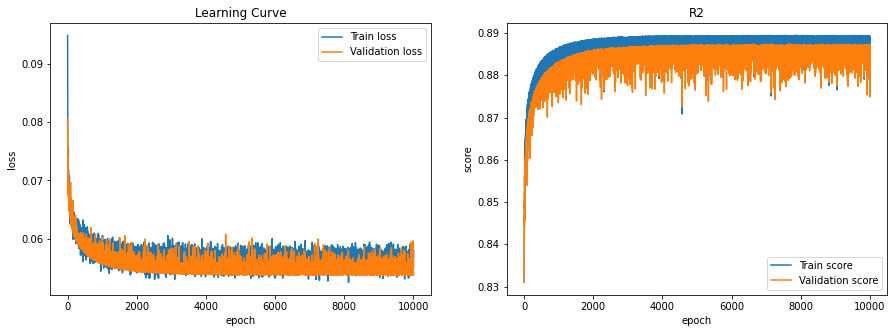

In [ ]:
batch_size = 10

sgd_ols.set_params(batch_size=batch_size,n_epochs=10000)
sgd_ridge.set_params(batch_size=batch_size,n_epochs=10000)

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'

fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)

The plots above confirms that too low batch size is less able to converge properly. As the loss curve becomes flat, indicating convergence, it starts to fluctuate wildly. This may indicate that it bounces around the optimal solution never being able to hit it properly, but always staying some amount away from it. It may be due to the fact that it's not using a lot of the data(small batch size). A batch size of 64 is used in further analysis


#### Momentum
Momentum can be used to achieve faster convergence(i.e fewer epochs are needed for similar results). When using momentum during sgd optimization, we are in essence keeping track of a moving avergage and adding it on every sgd step. Moving average is often used to smooth noisy curves as consistent changes affect the average much more than noise. In the same way, using momentum allows the optimization to be less sensitive to sudden changes in the gradient. In other words, if a direction is consistently good to follow then sudden changes in the gradient will not affect the course very much. Unless of course, the change starts to become consitent.
The 'momentum' parameter specifies the amount of the moving average we're adding on each iteration. We are using momentum=0.5 which is a rather standard value.

,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,2.942321,2.626199,2.396391,2.136511
2,1.721251,1.502108,1.348220,1.244489
3,-6.217680,-5.056661,-4.499408,-3.666583
4,-6.982377,-6.706709,-6.180578,-5.852382
5,-3.544113,-2.752259,-2.470205,-2.174631
6,6.891326,5.412366,4.930900,3.930073
7,9.201646,8.792859,8.218894,7.853615
8,2.417504,2.218686,1.815808,1.574966


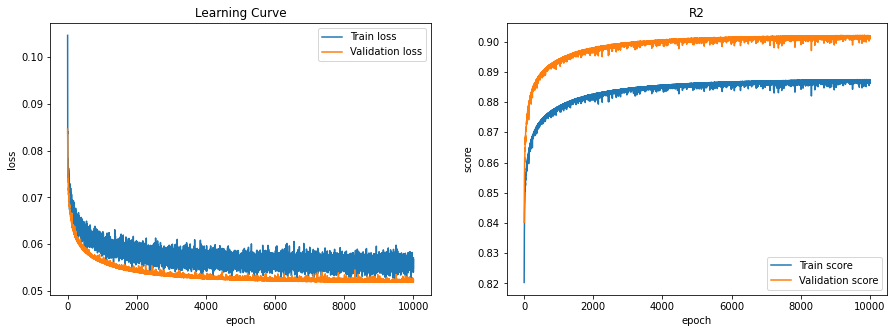

In [ ]:
n_epochs = 10000
batch_size = 64

sgd_ols.set_params(batch_size=batch_size,n_epochs = n_epochs, momentum=0.5)
sgd_ridge.set_params(batch_size=batch_size,n_epochs = n_epochs, momentum=0.5)

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'
fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

As can be seen the parameters are getting even closer with the same amount of epochs.

#### Learning rate
Increasing the learning rate will make the sgd optimizer take a "bigger" step on each iteration and may in turn result in faster convergence. However, if the learning rate is too high, the optimization might overshoot and miss the target(being the optimal solution) and possibly diverge.

,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,2.942321,2.995246,2.396391,2.290055
2,1.721251,1.679548,1.348220,1.269110
3,-6.217680,-6.324630,-4.499408,-4.301669
4,-6.982377,-6.969238,-6.180578,-6.049785
5,-3.544113,-3.522406,-2.470205,-2.212004
6,6.891326,7.127338,4.930900,4.719022
7,9.201646,9.205678,8.218894,8.105785
8,2.417504,2.448585,1.815808,1.644075


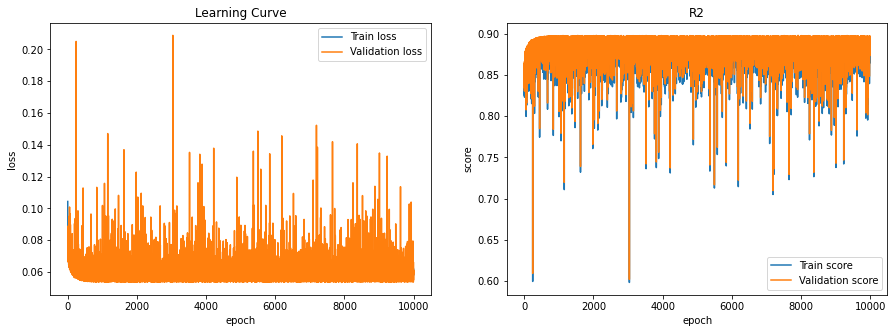

In [ ]:
lr0 = 0.1
batch_size=64

sgd_ols.set_params(lr0 = lr0,batch_size=batch_size)
sgd_ridge.set_params(lr0 = lr0,batch_size=batch_size)

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'
fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

The beta values are indeed even closer to the analytical ones. Though, looking at above plots it is clear the the loss and score are fluctuating heavily from epoch to epoch. This may be because with a 0.1 learning rate, the optimization overshoots causing the solution to bounce wildly around the optimal solution(minima). 

In [ ]:
sgd_ols.set_params(batch_size=batch_size,n_epochs = n_epochs, momentum=0.5)
lrs = np.logspace(-5, 2, 10)
scores = evaluate_parameter(sgd_ols,{'batch_size':batch_sizes},['MSE','R2'],X,z,X_scl,z_scl)
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(15,5)
plot_curves(scores['MSE'],batch_sizes,('Batch size','MSE'),ax = ax1, title='MSE',x_axis='semilog')
plot_curves(scores['R2'],batch_sizes,('Batch size','R2'),ax = ax2, title='R2',x_axis='semilog')

KeyboardInterrupt: 

comment result above

By applying a decaying learning rate schedule, the learning rate will decrease with increasing epochs. This can possibly mitigate the flucutations around the solution that may happen with high constant learning rates.


,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,3.025986,3.041078,2.461971,2.332681
2,1.687663,1.709891,1.324898,1.221645
3,-6.431900,-6.314668,-4.663601,-4.381044
4,-7.163027,-7.036123,-6.333869,-6.184436
5,-3.298784,-3.464474,-2.282368,-2.090889
6,7.048079,6.852098,5.035177,4.673557
7,9.477029,9.423449,8.450711,8.306855
8,2.479265,2.323052,1.865952,1.735943


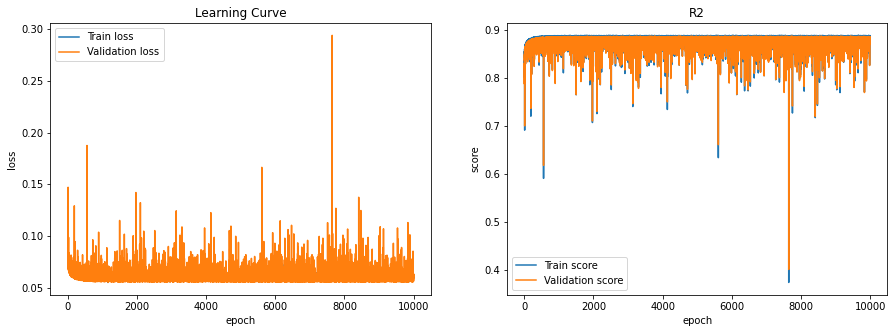

In [ ]:
lr0 = 0.1

sgd_ols.set_params(lr0=lr0,learning_shedule = 'decaying')
sgd_ridge.set_params(lr0=lr0,learning_shedule = 'decaying')

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'
fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

A quick test using a larger learning rate with a larger batch size is also tested. As stated above, larger batch sizes should be better at converging.

In [ ]:
lr0 = 0.1

sgd_ols.set_params(lr0 = lr0, batch_size = 512)
sgd_ridge.set_params(lr0 = lr0, batch_size = 512)

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'
fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

It is clear that with a decaying learning rate, the loss and score fluctuates less, however still exstensively. Perhaps the initial high learning rate is so high it immediately overshoots the solution.

A constant learning schedule is now compared to a decaying one with altering lr0.

In [ ]:
batch_size = 64
n_epochs = 10
lrs = np.logspace(-4, 0, 10)

sgd_ols.set_params(batch_size = batch_size, n_epochs=n_epochs,learning_shedule = 'constant')
scores_const = evaluate_parameter(sgd_ols,{'batch_size':batch_sizes},['MSE','R2'],X,z,X_scl,z_scl)

sgd_ols.set_params(batch_size = batch_size, n_epochs=n_epochs,learning_shedule = 'decaying')
scores_decaying = evaluate_parameter(sgd_ols,{'batch_size':batch_sizes},['MSE','R2'],X,z,X_scl,z_scl)

fig,ax =plt.subplots()
fig.set_size_inches(15,5)
plot_curves(scores_const['MSE'],lrs,('lr0','MSE'),ax = ax, title='Constant learning rate')
plot_curves(scores_decaying['MSE'],lrs,('lr0','MSE'),ax = ax, title='Decaying learning rate')

#### Comparing SGD regression to OLS
The SGD regression will be compared to the regular OLS, as well as to the sklearn's SGDRegressor. Now the polynomial degree of the design matrix will again be turned up to 8. Parameter selection should be performed on the same design matrix as the final model will use, as such, above analysis serves to  study the principal denpendancies between them.

In [ ]:
from sklearn.linear_model import SGDRegressor
from src.model_evaluation.resampling import cross_val_score

X, z = create_dataset('../../data/raw/SRTM_data_Norway_1.tif',degree=8) 

X_scl = StandardScaler().fit(X_train)
z_scl = StandardScaler().fit(z_train)

X_train = X_scl.transform(X_train)
X_test = X_scl.transform(X_test)
z_train = z_scl.transform(z_train)
z_test = z_scl.transform(z_test)

batch_size = 64
n_epochs = 10000
lr0 = 0.01
learning_shedule = 'constant'

sgd_ols.set_params(lr0 = lr0, batch_size = batch_size,n_epochs = n_epochs, learning_shedule=learning_shedule)
#Refit the models
sgd_ols.fit(X_train,z_train)

#Fit sk learn model for comparison
sgd_sk = SGDRegressor(fit_intercept = False, 
                      max_iter = 10000, 
                      penalty=None, 
                      eta0 = 0.01,
                      learning_rate='constant',
                      tol=None)
sgd_sk.fit(X_train,z_train.ravel())

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,sgd_sk.coef_.T)),
                  columns=['OLS','OLS SGD', 'OLS SGD sklearn'])
df.index.name = 'β'

own_ols_scores = cross_val_score(ols,X,z,5,X_scl,z_scl,['MSE','R2'])
own_sgd_scores = cross_val_score(sgd_ols,X,z,5,X_scl,z_scl,['MSE','R2'])
sk_scores = cross_val_score(sgd_sk,X,z,5,X_scl,z_scl,['MSE','R2'])

print(own_ols_scores)
print('\n')
print(own_sgd_scores)
print('\n')
print(sk_scores)
df


SGDRegressor(fit_intercept=False, penalty=None, tol=None)

As can be seen from the parameters above as well as the scores, the manually created code achieves similar results as those obtained using sklearn library. Additionally, both own sgd and sklearn achieves similar results as OLS.

In [ ]:
tilde_ols = ols.predict(X_train)
tilde_sgd = sgd_ols.predict(X_train)
tilde_sk = sgd_sk.predict(X_train)
pred_ols = ols.predict(X_test)
pred_sgd = sgd_ols.predict(X_test)
pred_sk = sgd_sk.predict(X_test)

X_ = np.concatenate((X_train,X_test))

plot_surf_from_X(X_,np.concatenate((tilde_ols,pred_ols)),'OLS')
plot_surf_from_X(X_,np.concatenate((tilde_sgd,pred_sgd)),'SGD OLS')
plot_surf_from_X(X_,np.concatenate((tilde_sk,pred_sk)),'SGD sklearn' )

array([ 0.        ,  0.32684152,  0.16490935,  0.70612802, -2.14398151,
        0.23711434,  0.47048395,  2.53684512, -0.29448518,  0.34044588,
       -1.43658895,  0.66575246, -1.74218854,  2.0026607 , -1.0713344 ])

From the surface plots it can be seen that all methods given enough epochs are able to construct convincing terrain map.

#### Tuning lr and lambda
A common first step when tuning a modelusing regularization is to find a satisfactory combination of learing rate and lambda. This is because a certain learning rate can work well with some values of lambda, but not others, and vice versa. This is indeed the case for most parameters, but perhaps more so with lr and lambda. The reason is that a large lr may cause large gradients and big changes to the parameters, while the regularization will subtract a portion of the parameter values at each update effectively punishing big changes.

One method to obtain a suitable combination of the parameters is to perform a gridsearch. Here two arrays of lambdas and learing rates are created. These contains the values one whishes to test. All models written in this project is implemented to work with SKlearn's GridSearch, as it provides efficient parallelization.

In [ ]:
from src.model_evaluation.param_analysis import grid_search_df
from src.visualization.visualize import plot_grid_search
nlambdas = 10
lambdas = np.logspace(-4, 2, nlambdas,dtype=np.double).round(5)
nlrs = 10
lrs = np.logspace(-4, 12, nlrs,dtype=np.double).round(5)
sgd_ridge.set_params(batch_size=batch_size,n_epochs=10000)

best_model, scores = grid_search_df(X_train,z_train,sgd_ridge, param_grid=dict(lmb=lambdas,lr0=lrs))
plot_grid_search(scores,('lmb','lr0'))